In [1]:
from icrl import *

d:\Anaconda3\envs\textgen\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bin d:\Anaconda3\envs\textgen\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


## Setup 1

In [2]:
num_actions = 10
conext_dim = 5
env = Environment(num_actions, conext_dim)

# LinUCB
linucb = LinUCB(num_actions, conext_dim)


100,000 trajactories, 200 time steps each

In [8]:
import tqdm
T = 200
num_trajectories = 10000

trajectories = [] # list of list of tuples [[(state,action,reward),...],...]
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar

for i in tqdm.tqdm(range(num_trajectories)):
    trajectory = []
    total_regret = 0
    regrets = []
    best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)

    for _ in range(T):
        action_index = linucb.select_action(env.action_set)
        reward, action = env.step(action_index)
        # find action
        linucb.update(reward, action)
        # Calculate regret for this round and add to total
        expected_reward = np.dot(env.action_set[action_index], env.w_star)
        
        round_regret = best_action_reward - expected_reward
        # print(round_regret)
        total_regret += round_regret
        
        trajectory.append((env.get_action_set(), action, reward))
        regrets.append(total_regret)

    all_regrets[i] = regrets # Store regrets for this trajectory
    trajectories.append(trajectory) # Store trajectory

    # Reset env and LinUCB for next trajectory
    env.reset()
    linucb.reset()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [06:00<00:00, 27.75it/s]


In [9]:
# Use dataframes to store the data
import pandas as pd
df_regrets= pd.DataFrame(all_regrets)
df_regrets.to_csv('linucb_regrets.csv', index=False)


# Save trajectories
import pickle
with open('linucb_trajectories.pkl', 'wb') as f:
    pickle.dump(trajectories, f)

In [10]:
# read data
df_regrets = pd.read_csv('linucb_regrets.csv')

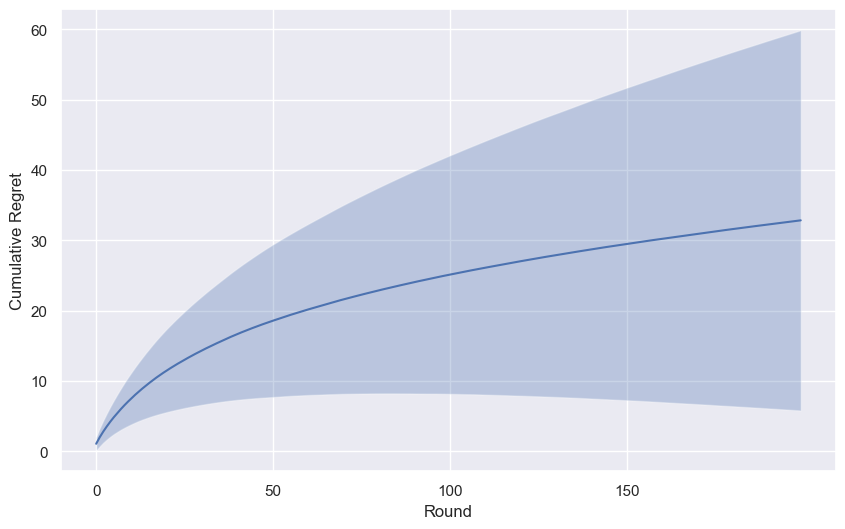

In [11]:
# Plot the average regret with confidence interval
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_regrets.mean(), label='LinUCB')
plt.fill_between(df_regrets.columns, df_regrets.mean() - df_regrets.std(), df_regrets.mean() + df_regrets.std(), alpha=0.3)
plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.savefig('linucb_regret.png')
plt.show()


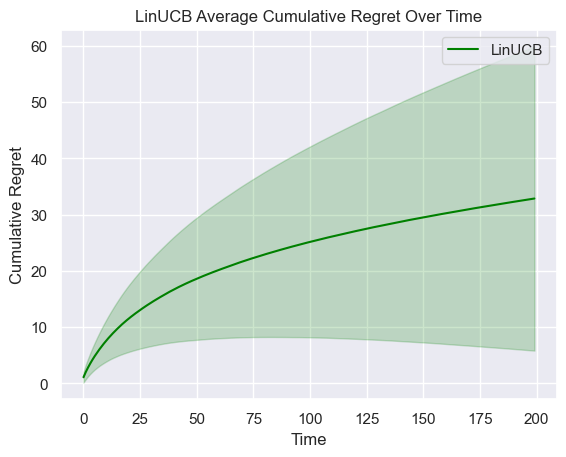

In [12]:
# 计算每一步的平均累计遗憾和标准差
average_regrets = df_regrets.mean(axis=0)
std_regrets = df_regrets.std(axis=0)

# 时间点
time_steps = np.arange(200)

# 绘制平均累计遗憾
plt.plot(time_steps, average_regrets, label='LinUCB', color='green')

# 绘制标准差阴影区域
plt.fill_between(time_steps, average_regrets - std_regrets, average_regrets + std_regrets, color='green', alpha=0.2)

# 设置图表标签和标题
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('LinUCB Average Cumulative Regret Over Time')
plt.legend()
plt.show()

# Thompson Sampling

In [2]:
num_actions = 10
conext_dim = 5

env = Environment(num_actions, conext_dim)
# Thompson Sampling
thompson = ThompsonSampling(num_actions, conext_dim)

In [11]:
import tqdm
T = 200
num_trajectories = 10000

trajectories = [] # list of list of tuples [[(state,action,reward),...],...]
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar

for i in tqdm.tqdm(range(num_trajectories)):

    total_regret = 0
    regrets = []
    best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
    states, actions, rewards = [], [], []

    for _ in range(T):
        action_index = thompson.select_action(env.action_set)
        reward, action = env.step(action_index)
        # find action
        thompson.update(reward, action)
        # Calculate regret for this round and add to total
        expected_reward = np.dot(env.action_set[action_index], env.w_star)
        
        round_regret = best_action_reward - expected_reward
        # print(round_regret)
        total_regret += round_regret

        # Store state, action, reward for this round
        states.append(env.get_action_set()) 
        actions.append(action)
        rewards.append(reward)
        regrets.append(total_regret)

    all_regrets[i] = regrets # Store regrets for this trajectory
    trajectories.append((states, actions, rewards)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    env.reset()
    thompson.reset()

  0%|          | 18/10000 [00:00<06:24, 25.98it/s]

In [ ]:
# Use dataframes to store the data
import pandas as pd
df_regrets= pd.DataFrame(all_regrets)
df_regrets.to_csv('Thompson_regrets.csv', index=False)


# Save trajectories
import pickle
with open('linucb_trajectories.pkl', 'wb') as f:
    pickle.dump(trajectories, f)

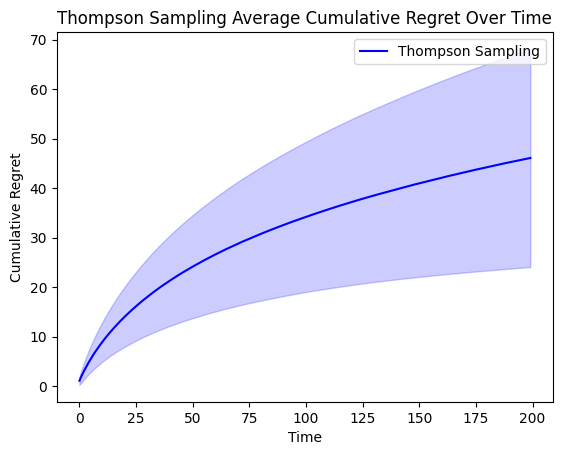

In [9]:
# 计算每一步的平均累计遗憾和标准差
average_regrets = df_regrets.mean(axis=0)
std_regrets = df_regrets.std(axis=0)

# 时间点
time_steps = np.arange(200)

# 绘制平均累计遗憾
plt.plot(time_steps, average_regrets, label='Thompson Sampling', color='blue')

# 绘制标准差阴影区域
plt.fill_between(time_steps, average_regrets - std_regrets, average_regrets + std_regrets, color='blue', alpha=0.2)

# 设置图表标签和标题
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Thompson Sampling Average Cumulative Regret Over Time')
plt.legend()
plt.show()